In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

#connecting database 
db = mysql.connector.connect(
    host = 'localhost',
    username = 'root',
    password = 'Aryan@MYSQL29',
    database = 'ecommerce'
)

curr = db.cursor()

# 1. List all unique cities where customers are located.

In [21]:
query = """ select distinct customer_city from customers"""

curr.execute(query)

data = curr.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [22]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

curr.execute(query)

data = curr.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.


In [23]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

curr.execute(query)

data = curr.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df





,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [24]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments """

curr.execute(query)

data = curr.fetchall()

"The percentage of orders that were paid in installments is ", data[0][0]

('The percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# 5. Count the number of customers from each state.

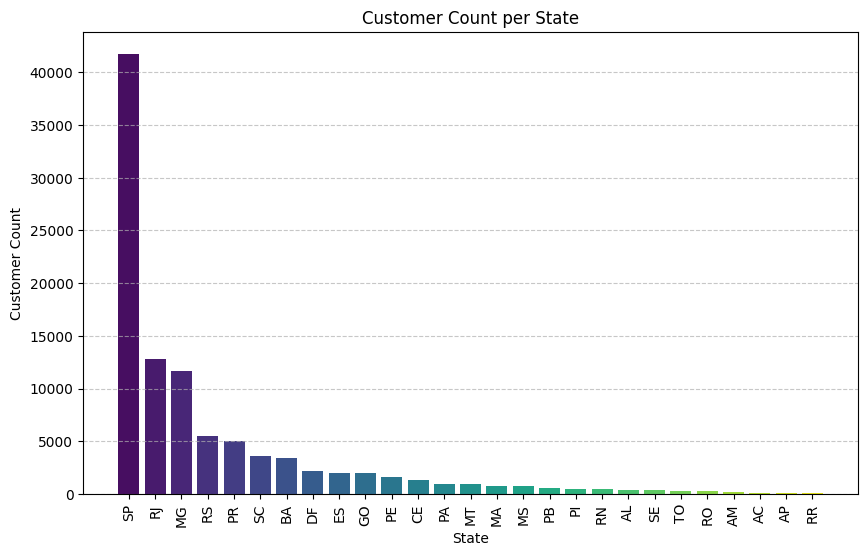

In [30]:
query = """ select customer_state, count(customer_id) from customers group by customer_state"""

curr.execute(query)
data = curr.fetchall()

df = pd.DataFrame(data, columns= ["state", "customer_count"])
df = df.sort_values(by="customer_count", ascending= False)

plt.figure(figsize= (10,6))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Customer Count per State")
plt.grid(axis="y", linestyle="--", alpha=0.7)

colors = sns.color_palette("viridis", len(df))
plt.bar(df["state"], df["customer_count"], color=colors)  

plt.show()

# 6. Calculate the number of orders per month in 2018.

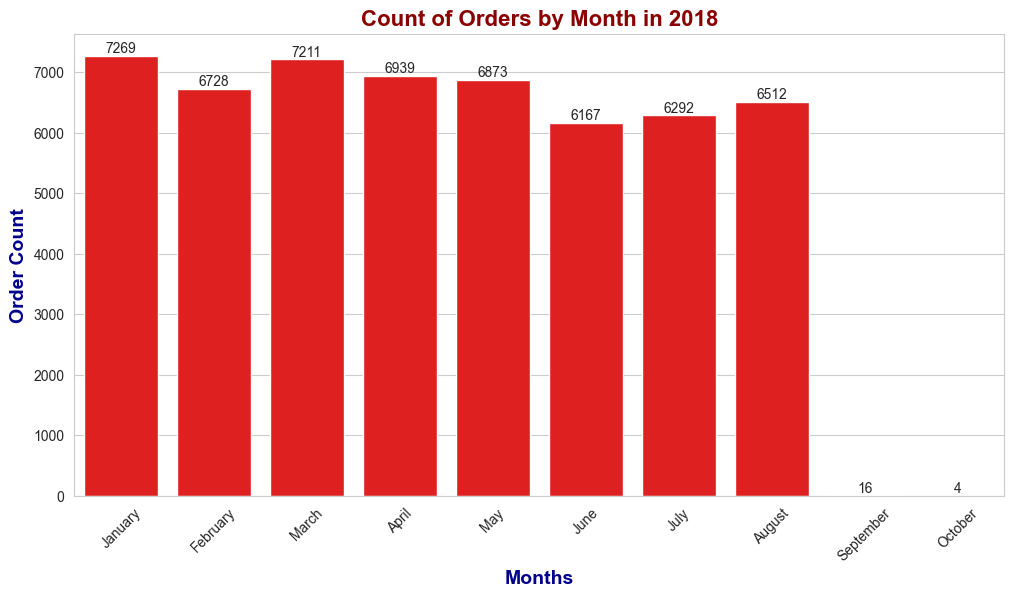

In [55]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

curr.execute(query)

data = curr.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.xlabel("Months", fontsize=14, fontweight="bold", color="darkblue")
plt.ylabel("Order Count", fontsize=14, fontweight="bold", color="darkblue")
plt.title("Count of Orders by Month in 2018", fontsize=16, fontweight="bold", color="darkred")

plt.show()

# 7. Find the average number of products per order, grouped by customer city.


In [57]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

curr.execute(query)

data = curr.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [63]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


curr.execute(query)
data = curr.fetchall()


df = pd.DataFrame(data,columns = ["Category", "Percentage Distribution"])
df.head()

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [65]:
curr = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

curr.execute(query)
data = curr.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation is", a[0][-1])

The correlation is -0.10631514167157567


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

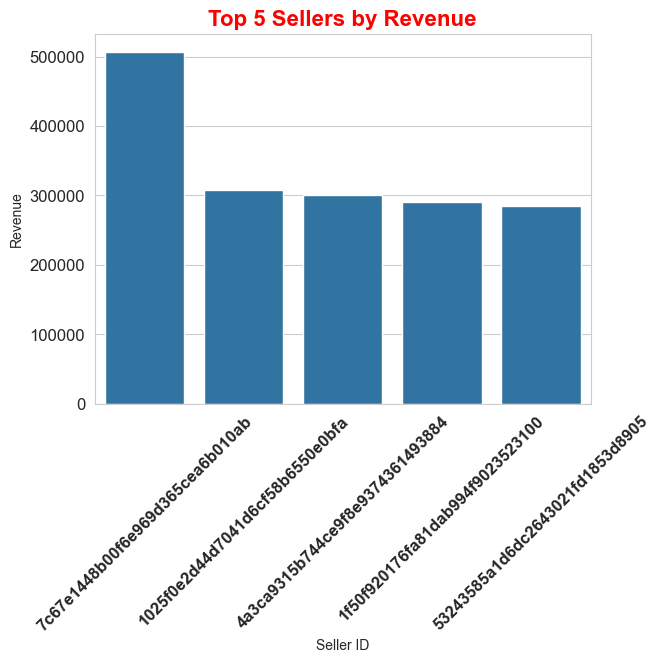

In [73]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

curr.execute(query)
data = curr.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)


plt.xticks(rotation=45, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12)
plt.xlabel("Seller ID")
plt.ylabel("Revenue")
plt.title("Top 5 Sellers by Revenue", fontsize=16, fontweight="bold", color="red")

plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [75]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
curr.execute(query)
data = curr.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [76]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
curr.execute(query)
data = curr.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales.

In [77]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

curr.execute(query)
data = curr.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [78]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

curr.execute(query)
data = curr.fetchall()

data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

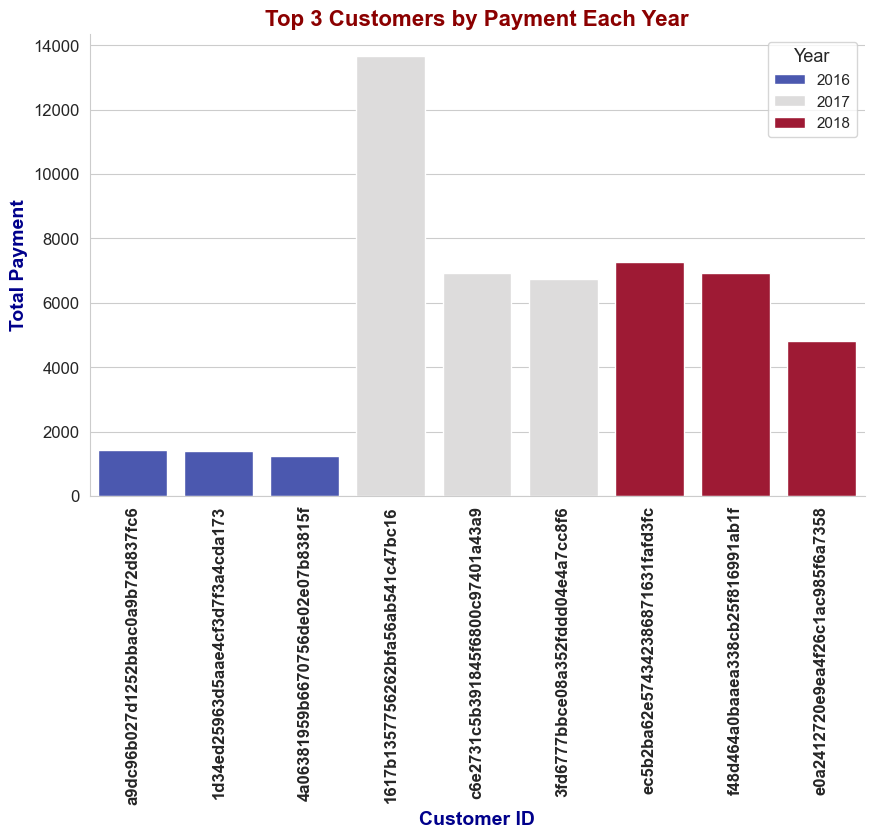

In [83]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

curr.execute(query)
data = curr.fetchall()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="id", y="payment", hue="years", data=df, palette="coolwarm")

plt.xticks(rotation=90, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12)
plt.xlabel("Customer ID", fontsize=14, fontweight="bold", color="darkblue")
plt.ylabel("Total Payment", fontsize=14, fontweight="bold", color="darkblue")
plt.title("Top 3 Customers by Payment Each Year", fontsize=16, fontweight="bold", color="darkred")

plt.legend(title="Year", title_fontsize=13, fontsize=11)

sns.despine()
plt.show()